<h1><center> Plot ATom aircraft data and region classification</center></h1>

<h4><center> Author: Anisbel León Marcos${^1}$ </center></h4>
<h6><center> ${^1}$Institute for Tropospheric Research (TROPOS)
</center></h6>
<h5><center> Contact information: </center></h5>
<h5><center> heinold@tropos.de (Bernd Heinold) </center></h5>
<br/>

#### Loading python packages 

In [1]:
import glob
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import codecs
import pandas as pd
import matplotlib.colors
import xarray as xr
import math
from datetime import datetime
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from dask.array import shape


In [2]:
#### Set data directory path
#### The in-situ aircraft observations were downloaded at  [https://doi.org/10.3334/ornldaac/1925]

In [11]:
base_path = f'/Users/Leon/Desktop/Folder_from_linux/Downloads/ATom-merge_ncfiles/MER-SAGA'

#### Define functions

In [12]:
def read_data(path_atom_meta):
    """ This function reads in the ATom in situ aircraft data from netcdf files
    Returns: all relevant variables needed from the dataset"""
    ds_atom_palms = xr.open_mfdataset(path_atom_meta,
                              group='PALMS-PartType-Mass', 
                              concat_dim = 'time', 
                              combine = 'nested', 
                              preprocess=lambda ds: 
                              ds[['SeaSaltMass_PALMS']])
    
    
    
    ds_atom_meta = xr.open_mfdataset(path_atom_meta,
                                     group='AMS', 
                                     concat_dim = 'time', 
                                     combine = 'nested', 
                                     preprocess=lambda ds: 
                                     ds[['ALT_AMS', 'LON_AMS', 'LAT_AMS','OA_PM1_AMS']])
    
    ds_atom_meta_p = xr.open_mfdataset(path_atom_meta,
                                     group='MMS', 
                                     concat_dim = 'time', 
                                     combine = 'nested', 
                                     preprocess=lambda ds: 
                                     ds[['P']]) 

    ds_atom_time = xr.open_mfdataset(path_atom_meta, 
                                     concat_dim = 'time', 
                                     combine = 'nested',
                                     preprocess=lambda ds: ds[['time']])
    
    return ds_atom_palms,ds_atom_meta,ds_atom_time,ds_atom_meta_p

In [13]:
def find_region(var_set,cond,dicc,sub_na):
    """ This function is used to select and filter certain regions according to the conditions variable (cond). 
    var_set is the list of variables, dicc is the dictionary containing the regions of key argument sub_na
    Returns the dictionary variable (dicc) with the data filtered to meet each condition"""
    variables = []
    for i,v in enumerate(var_set):
        if len(cond) <= 1:
            v = v.where((cond[0][0]>cond[0][1]) &
                        (cond[0][0]<cond[0][2])
                        ,drop=True)
        elif len(cond) > 1:
            v = v.where(((cond[0][0]>cond[0][1]) & 
                     (cond[0][0]<cond[0][2]) &
                     (cond[1][0]>cond[1][1]) & 
                     (cond[1][0]<cond[1][2]))
                     ,drop=True)
        
        variables.append(v)
        dicc[sub_na[i]] = v
    return dicc,variables


In [14]:
def get_duplic_month(ds_atom):
    """ This function returns the list of months and years when the data was sampled"""
    list_number = []
    list_duplic = []
    init_date = []

    m_init = ds_atom['time'].dt.month.values[0]
    n = 0
    n_id = 1
    for i, m in enumerate(ds_atom['time'].dt.month.values):
        if m == m_init:
            n+=1
            list_duplic.append(n_id)
        else:
            list_number.append(n)
            if ds_atom['time'][i].dt.month.values > 9:
                mon = str(ds_atom['time'][i].dt.month.values)
            else:
                mon = '0'+str(ds_atom['time'][i].dt.month.values)       
            date = str(ds_atom['time'][i].dt.year.values)+'-'+ mon
            init_date.append(date)
            n = 1
            n_id +=1
            list_duplic.append(n_id)


        m_init = m
    list_number.append(n)
    return list_duplic, init_date

In [15]:
path_atom_meta

'./ATom-merge_ncfiles/MER-SAGA*1.nc'

### Reading ATom netcdf files


#### Reading and plotting data per campaign

In [16]:
colors = ['r', 'b', 'g', 'm']
names = ['ATom-1', 'ATom-2', 'ATom-3', 'ATom-4']
dates = []
altitude = []
oa_mass = []
lon_list, lat_list = [], []
for i in range(4):
    var_list_atom = ['N_accum_AMP']
    path_atom_meta = f'{base_path}*{i + 1}.nc'
    ds_atom_c, ds_atom_meta, ds_atom_time, _ = read_data(path_atom_meta)

    ds_atom_meta = ds_atom_meta.where(ds_atom_meta['ALT_AMS'].compute() < 1000, drop='True')
    ds_atom_meta = ds_atom_meta.where((ds_atom_meta['OA_PM1_AMS'].compute() > 0.) &
                                      (ds_atom_meta['OA_PM1_AMS'].compute() < 0.2),
                                        drop='True')

    oa_mass.append(ds_atom_meta['OA_PM1_AMS'].values)
    dates.append([datetime.strptime(str(m), '%Y-%m-%dT%H:%M:%S.000000000') for m in ds_atom_time['time'].values])
    altitude.append(ds_atom_meta['ALT_AMS'].values / 1000)
    lat_list.append(ds_atom_meta['LAT_AMS'].values)
    lon_list.append(ds_atom_meta['LON_AMS'].values % 360)

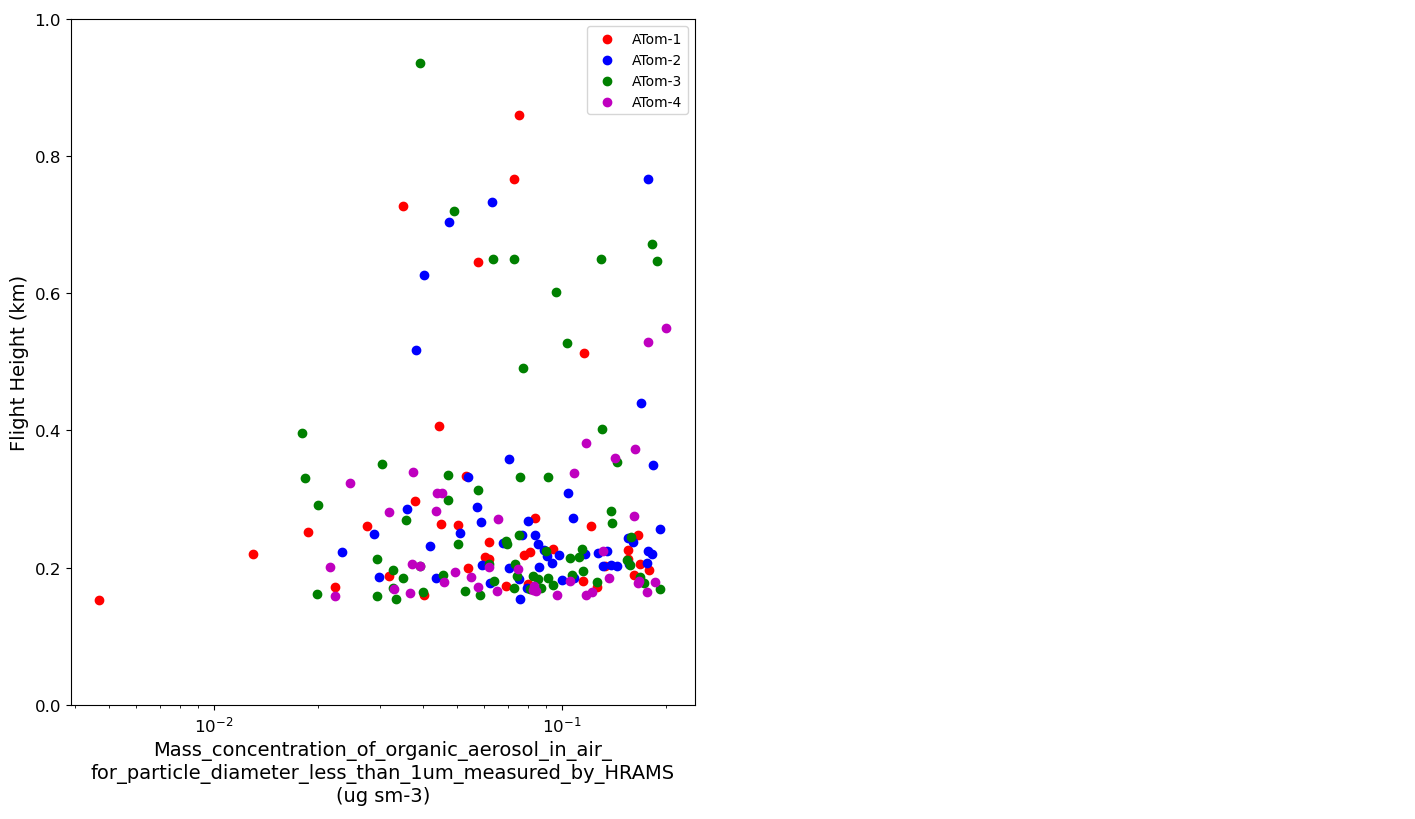

In [17]:
fig = plt.figure(constrained_layout=True, figsize=(14, 8))
(subfig1,subfig2) = fig.subfigures(nrows = 1, ncols = 2)
subfigs = [subfig1,subfig2]
ax = subfig1.subplots(nrows=1, ncols=1)
for i,axs in enumerate(colors):
    ax.scatter(oa_mass[i],altitude[i],c = colors[i],label=names[i])
    ax.tick_params(axis = 'both',labelsize = '12')
    ax.axhline(y = 2, color = 'k', linestyle = '--')

ax.set_ylim([0,1])
ax.set_ylabel('Flight Height (km)',fontsize = 14)
ax.set_xlabel('Mass_concentration_of_organic_aerosol_in_air_\n'
                 'for_particle_diameter_less_than_1um_measured_by_HRAMS\n(ug sm-3)'
             ,fontsize = 14)
ax.set_xscale('log')


ax.legend()
plt.savefig('mass_conc_OA_flight_height.png',dpi = 300)

#### Reading all data together for regions classification


In [18]:
path_atom_meta = f'{base_path}*.nc'
ds_atom_c,ds_atom_meta,ds_atom_time,ds_atom_meta_p = read_data(path_atom_meta)


#### Filtering the data for heights lower than 1km and 0.2 $\mu g s m^{-3}$

In [19]:
ds_atom_c['P'] = ds_atom_meta_p['P']*100

ds_atom = ds_atom_c.assign(lat=ds_atom_meta['LAT_AMS'], 
                           lon=ds_atom_meta['LON_AMS']%360, 
                           alt=ds_atom_meta['ALT_AMS'],
                           OA_PM1_AMS=ds_atom_meta['OA_PM1_AMS'],
                           time=ds_atom_time['time'])


# selecting only atom levels under 1 km height
ds_atom=ds_atom.where(ds_atom['alt'].compute()<1000,drop = 'True')
ds_atom=ds_atom.where((ds_atom['OA_PM1_AMS'].compute()>0.)&(ds_atom['OA_PM1_AMS'].compute()<0.2),drop = 'True')


#### Defining regions and filtering the data for each region

In [20]:
lat = ds_atom['lat'].compute()
lon = ds_atom['lon'].compute()
data = ds_atom['SeaSaltMass_PALMS'].compute()
alt = ds_atom['alt'].compute()
pres = ds_atom['P'].compute()
date = ds_atom['time'].compute()


reg_data = {'South Atlantic':[],
            'South Pacific':[],
            'Central Pacific':[],
            'Northern Oceans': [],
            'N. Atlantic':[],
            'N. Pole': [],

           }

subkeys = {'latitud': [],
           'longitud': [],
           'aer_data': [],
           'model_data': [],
           'altitude': [],
           'pressure': [],
           #'time': []
           }

conditions = [[[lat, -90, 0], [lon, 290, 360]],
              [[lat, -90, -23], [lon, 130, 293]],
              [[lat, -23, 23], [lon, 130, 293]],
              [[lat, 23, 60], [lon, 130, 240]],
              [[lat, 0, 60], [lon, 300, 360]],
              [[lat, 60, 90]],
             ]

#     return conditions
for na in reg_data.keys():
    reg_data[na]={'latitud':[],
                 'longitud':[],
                 'aer_data':[],
                 'model_data':[],
                 'altitude': [],
                 'pressure': [],
                 'time':[]
                  }
    

color_reg = ['y','r','lightgreen','lightgray','lightgray','lightgray']
marker_list = ['o', 'X', 's', 'd', 'd', 'd']

for i,na in enumerate(reg_data.keys()):
    l = 0 
    sub_na = list(reg_data[na].keys())
    variables = [lat,lon,data,alt,pres,date]
    reg_data[na],_ = find_region(variables,
                               conditions[i],
                               reg_data[na],
                               sub_na)

### Plotting ATom aircraft trajectories (with the dates information) and regions definition for model evaluation

In [21]:
fig,axs = plt.subplots(nrows=1, ncols=2,figsize=(16, 7),
                       subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
ax = axs.flatten()


cb = []
for i,na in enumerate(reg_data.keys()):
    cb.append(ax[1].scatter(reg_data[na]['longitud'],reg_data[na]['latitud'], c =color_reg[i], marker=marker_list[i], label=na,
                    transform = ccrs.PlateCarree()))

ax[1].coastlines()
ax[1].gridlines()
ax[1].set_title(r'$\bf{(b)}$',loc = 'left',fontsize=18)
handles, labels = ax[1].get_legend_handles_labels()
labels_new = labels.append('Northern Oceans')
print(handles[:3])
ax[1].legend(labels = labels_new, handles=handles[:4],
             loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=2, fontsize = 16)


cmap = plt.get_cmap('plasma_r', 10)


da_count_month, init_date = get_duplic_month(ds_atom)
n = len(init_date)
print(n)
cmap = plt.get_cmap("jet", n)
norm= matplotlib.colors.BoundaryNorm(np.arange(0,n+1)-0.5, n)

cb = ax[0].scatter(ds_atom.lon, 
                ds_atom.lat, 
                c=da_count_month,cmap=cmap,norm=norm,
                transform = ccrs.PlateCarree())
cax = fig.add_axes([0.125, ax[0].get_position().y0-0.1, 0.356, 0.035])
cbar = fig.colorbar(cb, ticks=np.arange(0,n),cax = cax, orientation = 'horizontal')
cbar.set_ticklabels(init_date, fontsize=14) # set ticks of your format
ax[0].set_title(r'$\bf{(a)}$',loc = 'left',fontsize=18)

ax[0].coastlines()


# add grid lines
for axs in ax:
    gl = axs.gridlines(draw_labels=True, 
                      x_inline=False, 
                      y_inline=False) 
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 14}
    gl.ylabel_style = {'size': 14}

plt.savefig(f'ATom_region_classification.png', bbox_inches='tight')
plt.close()

[<matplotlib.collections.PathCollection object at 0x169eef8c0>, <matplotlib.collections.PathCollection object at 0x168f317f0>, <matplotlib.collections.PathCollection object at 0x16892ffe0>]
6


### Plotting vertical profile of data for each ATom campaign (including map of flight trajectories)

In [23]:
fig, ax0 = plt.subplots(figsize=(12, 8))
proj = ccrs.PlateCarree(central_longitude=180)
ax1 = fig.add_axes([0.08, 0.47, 0.4, 0.4], projection=proj)

for i,axs in enumerate(colors):
    ax0.scatter(oa_mass[i],altitude[i],c = colors[i],label=names[i])
    ax0.tick_params(axis = 'both',labelsize = '12')
    ax0.axhline(y = 0.15, color = 'k', linestyle = '--', alpha=0.5)
    ax0.axhline(y = 0.4, color = 'k', linestyle = '--', alpha=0.5)

    count = 0
    for j in range(len(altitude[i])):
        if altitude[i][j]<0.4:
            count+=1
    print('ATom ', i+1, 'No. obs ', len(altitude[i]), ', % below 0.4 km ', count*100/len(altitude[i]))

    cb = ax1.plot(lon_list[i],
                     lat_list[i],
                     c=colors[i],
                     transform=ccrs.PlateCarree())
ax1.coastlines() 
ax0.set_ylim([0,1])
ax0.set_ylabel('Sampling height (km)',fontsize = 18)
ax0.set_xlabel('OA mass concentration (µg m$^{-3}$)'
             ,fontsize = 18)
# 'Mass_concentration_of_organic_aerosol_in_air_\n''for_particle_diameter_less_than_1um_measured_by_HRAMS\n(ug sm-3)'
ax0.set_xscale('log')
ax0.legend()
handles, labels = ax0.get_legend_handles_labels()
labels_new = labels.append('Northern Oceans')
ax0.legend(labels = labels_new, handles=handles[:4],
             loc='upper center', bbox_to_anchor=(0.5, 1.1),
          fancybox=True, shadow=True, ncol=4, fontsize = 18)
ax0.tick_params(axis='both', labelsize='18')

ax1.tick_params(axis='both', labelsize='18')
ax1.coastlines()
ax1.gridlines()


plt.savefig(f'ATom_flight_trajectories_under1km.png', bbox_inches='tight')
plt.close()

ATom  1 No. obs  38 , % below 0.4 km  84.21052631578948
ATom  2 No. obs  51 , % below 0.4 km  88.23529411764706
ATom  3 No. obs  64 , % below 0.4 km  82.8125
ATom  4 No. obs  40 , % below 0.4 km  95.0
